## MLP  

This notebook shows a process of finding the best data set and subsequently tuning hyper parameters for the best outcome

### Importing necessary modules

In [1]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from dask.distributed import Client, progress
import dask
import joblib
import dask.array as da
from dask import delayed
from dask_ml.wrappers import ParallelPostFit

#### Helper functions

In [2]:
def plot_confusion_matrix(mlp, X_test, y_test, text_labels, title):
    y_test_pred = mlp.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=text_labels, yticklabels=text_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

### Getting the data

In [3]:
data = pd.read_csv('Added_Features.csv')

#### Extracting the classification classes  

The label_encoder can be used when the model is not able to accept text data for classes instead of numerical ones. In that case the text labels are converted to numbers for 0 to len(classes) - 1. However, for the sklearn library that conversion was not necessary

In [4]:
y = data["Class"].values
num_classes = len(np.unique(y))

# encode strings to numbers 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

text_labels = np.unique(y)
print(text_labels)

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


#### Defining the input parameters from the data  

For the initial test only the most basic data - namely the band mean from bands 2, 3, 4 and 8 is taken into account. The number of features is then extracted from the chosen input.

In [5]:
X = data[["Band_2_mean", "Band_3_mean", "Band_4_mean", "Band_8_mean"]].values
num_features = X.shape[1]

### Defining the model  

For the initial evaluation the standard MLP model from the sklearn library is used

In [6]:
mlp_basic = MLPClassifier()

### Splitting the data  

The data is split to training validation and loss with proportions 60:20:20

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Fitting the model and then checking results 

Only checking the results for validation as for the test, without the parameters optimization they will be very similar

In [8]:
mlp_basic.fit(X_train, y_train)

MLPClassifier()

In [9]:
y_val_pred = mlp_basic.predict(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy_val}")

Validation Accuracy: 0.5085185185185185


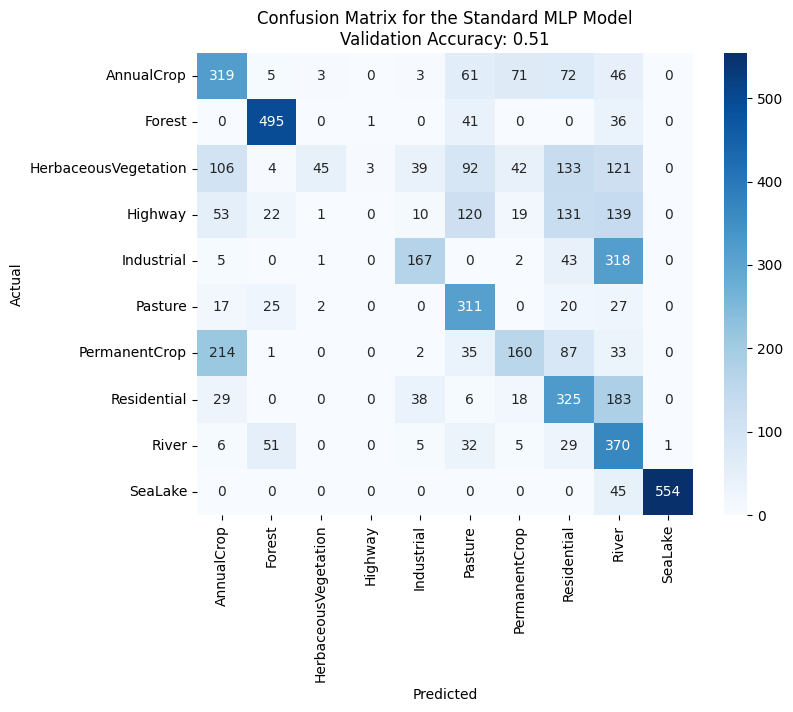

In [10]:
main_title = "Confusion Matrix for the Standard MLP Model"
validation_accuracy = "Validation Accuracy: {:.2f}".format(accuracy_val)
title = main_title + '\n' + validation_accuracy
plot_confusion_matrix(mlp_basic, X_val, y_val, text_labels, title)

#### Improving the model architecture  


The standard model is very basic, which is to be expected. Therefore a new model is constructed which has more hidden layers than the standard one

In [11]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 128, 64), max_iter=1000, random_state=42)

#### Checking the results

In [12]:
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 128, 64), max_iter=1000, random_state=42)

In [13]:
y_val_pred = mlp.predict(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy_val}")

Validation Accuracy: 0.6774074074074075


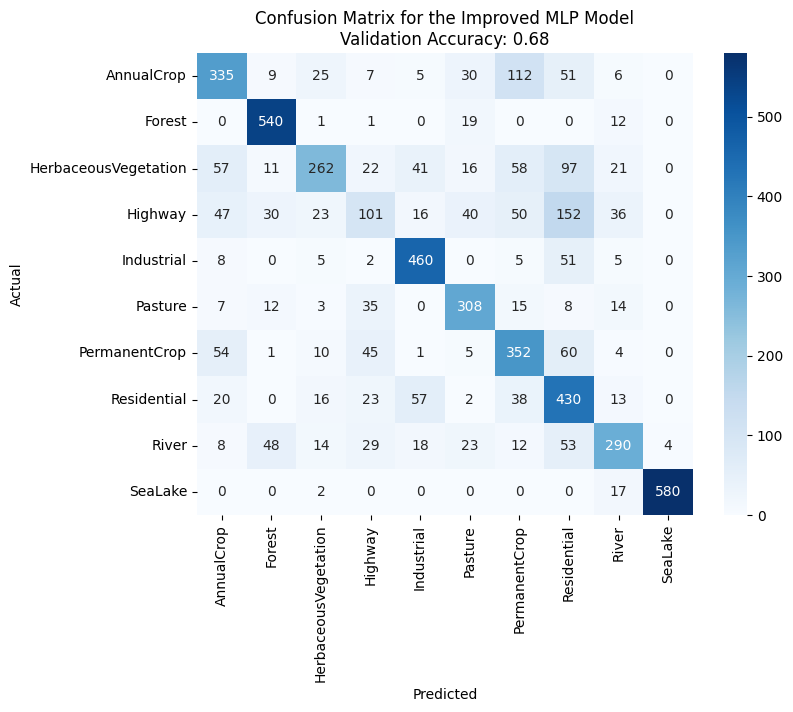

In [14]:
main_title = "Confusion Matrix for the Improved MLP Model"
validation_accuracy = "Validation Accuracy: {:.2f}".format(accuracy_val)
title = main_title + '\n' + validation_accuracy
plot_confusion_matrix(mlp, X_val, y_val, text_labels, title)

As can be seen this model performs better than the standard one.  

The following section of this report will examine how different input data influences the accuracy result of the model

## Different inputs  

The section below shows graphs for different input values, the workflow is identical to the one showed above: defining the X data, the model, splitting the data, fitting the model and finally evaluating. Hence, not to repeat the code in this section only the resulting confusion matrix are shown.

In [15]:
print("All the possible input values")
data.columns

All the possible input values


Index(['Unnamed: 0', 'Index', 'Lat', 'Lon', 'Class', 'Band_2_mean',
       'Band_2_max', 'Band_2_min', 'Band_3_mean', 'Band_3_max', 'Band_3_min',
       'Band_4_mean', 'Band_4_max', 'Band_4_min', 'Band_8_mean', 'Band_8_max',
       'Band_8_min', 'Band_2_range', 'Band_3_range', 'Band_4_range',
       'Band_8_range', 'NDVI_mean', 'NDVI_max', 'NDVI_min', 'NDVI_range',
       'NDWI_mean', 'NDWI_max', 'NDWI_min', 'NDWI_range', 'EVI_mean',
       'EVI_max', 'EVI_min', 'EVI_range', 'SAVI_mean', 'SAVI_max', 'SAVI_min',
       'SAVI_range'],
      dtype='object')

<div style="display: flex; justify-content: center;">
  <img src="images/BandsMeanRanges.png" alt="Image 1" style="width: 49%; margin: 0 10px;">
  <img src="images/BandsAll.png" alt="Image 2" style="width: 49%; margin: 0 10px;">
</div>

<div style="display: flex; justify-content: center;">
  <img src="images/BandsAllIndexMeans.png" alt="Image 1" style="width: 49%; margin: 0 10px;">
  <img src="images/BandsAllIndexMeansRanges.png" alt="Image 2" style="width: 49%; margin: 0 10px;">
</div>

<div align="center">
  <img src="images/AllData.png" alt="Image Description" width="70%">
</div>


The model trained on all data regarding the bands performed the best and the model including also the mean and range values of the indexes came closely second. For the parameter optimization and the further analysis the second best model is chosen as we wanna explore the impact of the features created by us. Moreover, all the models with more data performed better than the original one.

##  Hyperparameter Optimization

### Visualizing the overfitting

Firstly **grid search** is used for the hyperparameter optimization

In [16]:
X = data[['Band_2_mean',
       'Band_2_max', 'Band_2_min', 'Band_3_mean', 'Band_3_max', 'Band_3_min',
       'Band_4_mean', 'Band_4_max', 'Band_4_min', 'Band_8_mean', 'Band_8_max',
       'Band_8_min', 'Band_2_range', 'Band_3_range', 'Band_4_range',
       'Band_8_range', 'NDVI_mean', 'NDWI_mean', 'EVI_mean', 'SAVI_mean', 'NDVI_range', 'NDWI_range', 'EVI_range', 'SAVI_range']].values
num_features = X.shape[1]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:
grid = {
    'hidden_layer_sizes': [(64, 128, 64), (128, 256, 128)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test) 
print(f'Accuracy of Best Model: {accuracy}')

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 256, 128)}
Accuracy of Best Model: 0.7738888888888888


```Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 256, 128)}
Accuracy of Best Model: 0.7738888888888888```

#### Over fitting

As for now the number of epochs is set to 1000 it is very likely  that overfilling occurs. The graph below shows the difference between the accuracy loss for training and validation

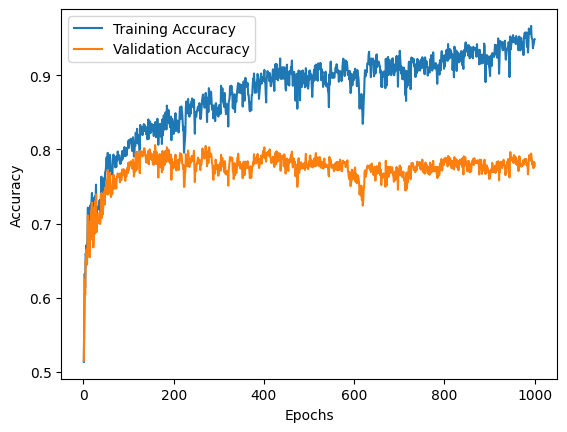

In [18]:
mlp = MLPClassifier(hidden_layer_sizes=((128, 256, 128)), max_iter=1000, random_state=42, alpha = 0.0001)

train_loss = []
val_loss = []

for i in range(1000):
    # partial_fit runs for only one epoch
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

    train_loss.append(mlp.score(X_train, y_train))

    val_loss.append(mlp.score(X_val, y_val))

plt.plot(range(1, len(train_loss)+1), train_loss, label='Training Accuracy')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

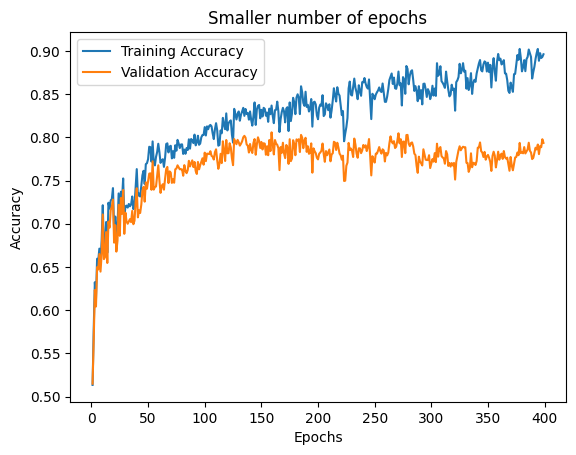

In [19]:
plt.plot(range(1, 400), train_loss[:399], label='Training Accuracy')
plt.plot(range(1, 400), val_loss[:399], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Smaller number of epochs')
plt.legend()
plt.show()

From the graphs we can deduce that the model begins to overfit (for this particular parameter configuration) at around 80 epochs)

### Parameter optimization with overfitting prevention  

Now to the grid search the parameter early_stop is introduced. It makes it that model stops training when the validation score is not improving.

In [20]:
X = data[['Band_2_mean',
       'Band_2_max', 'Band_2_min', 'Band_3_mean', 'Band_3_max', 'Band_3_min',
       'Band_4_mean', 'Band_4_max', 'Band_4_min', 'Band_8_mean', 'Band_8_max',
       'Band_8_min', 'Band_2_range', 'Band_3_range', 'Band_4_range',
       'Band_8_range', 'NDVI_mean', 'NDWI_mean', 'EVI_mean', 'SAVI_mean', 'NDVI_range', 'NDWI_range', 'EVI_range', 'SAVI_range']].values
num_features = X.shape[1]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
grid = {
    'hidden_layer_sizes': [(64, 128, 64), (128, 256, 128), (256, 512, 256), (64, 128)], 
    'activation': ['relu'], 
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping':[True]

}

# Create the GridSearchCV object
grid_search = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)  
print(f'Accuracy of Best Model: {accuracy}')

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (256, 512, 256)}
Accuracy of Best Model: 0.7561111111111111


```Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (256, 512, 256)}
Accuracy of Best Model: 0.7561111111111111```

The lower score than original in the parameter estimation shows that the original models most likely were overfitted. Therefore the training is run once again for the best possible model while ensuring it will not overfit

In [22]:
model_improved = MLPClassifier(hidden_layer_sizes=(256, 512, 256), max_iter=1000, random_state=42, early_stopping=True, activation = 'relu', alpha = 0.01)
model_improved.fit(X_train, y_train)

MLPClassifier(alpha=0.01, early_stopping=True,
              hidden_layer_sizes=(256, 512, 256), max_iter=1000,
              random_state=42)

In [23]:
y_val_pred = model_improved.predict(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy_val}")

Validation Accuracy: 0.7533333333333333


Plotting with the test score

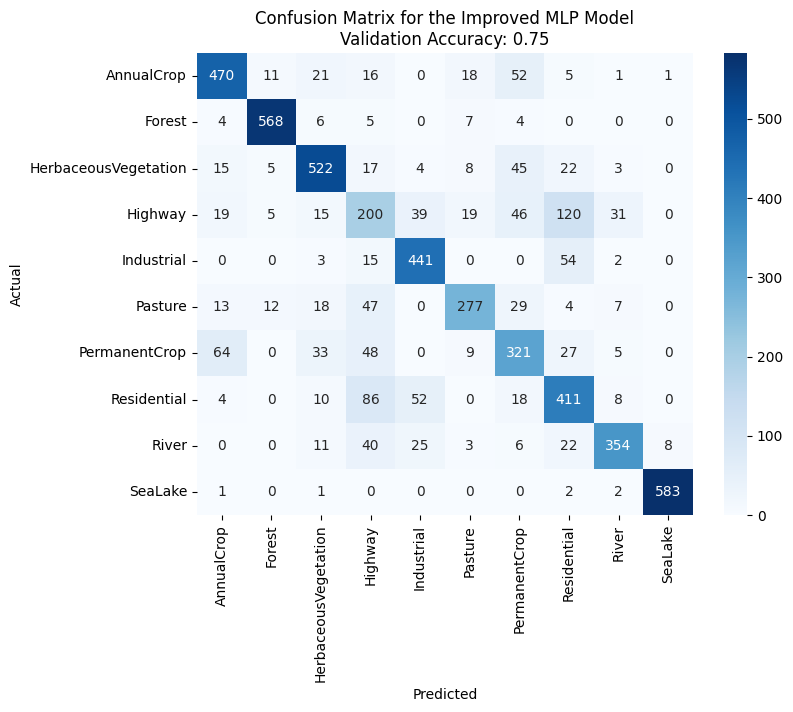

In [24]:
main_title = "Confusion Matrix for the Improved MLP Model"
validation_accuracy = "Validation Accuracy: {:.2f}".format(accuracy_val)
title = main_title + '\n' + validation_accuracy
plot_confusion_matrix(mlp, X_test, y_test, text_labels, title)

# Dask  

Implementation of this section is done following https://examples.dask.org/machine-learning/scale-scikit-learn.html 

Drag the client from the crib:

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44405")
client

<Client: 'tcp://127.0.0.1:44405' processes=4 threads=8, memory=28.00 GiB>

###  Fitting the model in dask

In [6]:
X = data[['Band_2_mean',
       'Band_2_max', 'Band_2_min', 'Band_3_mean', 'Band_3_max', 'Band_3_min',
       'Band_4_mean', 'Band_4_max', 'Band_4_min', 'Band_8_mean', 'Band_8_max',
       'Band_8_min', 'Band_2_range', 'Band_3_range', 'Band_4_range',
       'Band_8_range', 'NDVI_mean', 'NDWI_mean', 'EVI_mean', 'SAVI_mean', 'NDVI_range', 'NDWI_range', 'EVI_range', 'SAVI_range']].values

num_features = X.shape[1]

In [7]:
X_dask = da.from_array(X, chunks=(5000, num_features))
y_dask = da.from_array(y, chunks=5000)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_dask, y_dask, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
%%time
mlp = MLPClassifier(hidden_layer_sizes=(256, 512, 256), max_iter=1000, random_state=42, early_stopping=True, activation = 'relu', alpha = 0.01)

# Train the model using Dask
mlp_parallel = ParallelPostFit(mlp)
mlp_parallel.fit(X_train, y_train)

# Predict using the parallel post-fit wrapper
y_pred = mlp_parallel.predict(X_test)

# Evaluate the predictions
accuracy = (y_pred == y_test).mean()
accuracy_result = accuracy.compute()
print(f'Accuracy of Best Model: {accuracy}')

Since dask is lazy

In [ ]:
print(f'Actual accuracy of Best Model: {accuracy_result}')

Accuracy was ```76.70```
With this chunking the accuracy is higher than with the non dask run

#### Different chunk size - 1000

In [7]:
X_dask = da.from_array(X, chunks=(1000, num_features))
y_dask = da.from_array(y, chunks=1000)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_dask, y_dask, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(256, 512, 256), max_iter=1000, random_state=42, early_stopping=True, activation = 'relu', alpha = 0.01)

# Train the model using Dask
mlp_parallel = ParallelPostFit(mlp)
mlp_parallel.fit(X_train, y_train)

# Predict using the parallel post-fit wrapper
y_pred = mlp_parallel.predict(X_test)

# Evaluate the predictions
accuracy = (y_pred == y_test).mean()
accuracy_result = accuracy.compute()
print(f'Actual accuracy of Best Model: {accuracy_result}')

Accuracy was ```76.56```
Accuracy bit lower then the previous one but barely - trying  even smaller chunk

In [ ]:
X_dask = da.from_array(X, chunks=(100, num_features))
y_dask = da.from_array(y, chunks=100)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_dask, y_dask, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
%%time
mlp = MLPClassifier(hidden_layer_sizes=(256, 512, 256), max_iter=1000, random_state=42, early_stopping=True, activation = 'relu', alpha = 0.01)

# Train the model using Dask
mlp_parallel = ParallelPostFit(mlp)
mlp_parallel.fit(X_train, y_train)

# Predict using the parallel post-fit wrapper
y_pred = mlp_parallel.predict(X_test)

# Evaluate the predictions
accuracy = (y_pred == y_test).mean()
accuracy_result = accuracy.compute()
print(f'Actual accuracy of Best Model: {accuracy_result}')

Accuracy was ```76.75```
With the smaller chunk the time it took to fit the model was longer however the accuracy is slightly improved

In [ ]:
client.shutdown()